Look at where points fall relative to the center of a pointing, ignoring camera rotation.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.batches as batches
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from scipy.stats import uniform, kstest

In [2]:
def compass_bearing(lon1, lat1, lon2, lat2):
    """Calculate the bearing between two points
    
    Parameters
    ----------
    lon1 : float (or array)
        The longitude(s) for starting point(s) (radians)
    lat1 : float (or arrray)
        The latitudes(s) for the starting point(s) (radians)
    lon2 : float (or array)
        The longitude for the ending point(s) (radians)
    lat2 : float (or array)
        The latitude for the ending point(s) (radians)
        
    Returns
    -------
    bearing in radians (between 0 and 2pi)
        
    """
    long_diff = lon2 - lon1
    x = np.sin(long_diff)*np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(long_diff)
    result = np.arctan2(x, y)
    result = (result+2*np.pi) % (2.*np.pi)
    return result

In [3]:
np.degrees(compass_bearing(np.radians(65.), np.radians(37.0), np.radians(65.), np.radians(35.)))

180.0

In [4]:
class AngleDist2PointingCenter(metrics.BaseMetric):
    """See how flat the distributing of angles pointing to the center of the FoV is
    
    Uses the KStest statistic--values of 0 are perfectly uniform, values of 1 are totally non-uniform.
    """
    def __init__(self, latCol='dec', lonCol='RA', degrees=True,
                 metricName='Pointing Center Distribution', **kwargs):
        # Make a uniform distribution beween 0 and 2pi
        col = [latCol, lonCol]
        self.latCol = latCol
        self.lonCol = lonCol
        super(AngleDist2PointingCenter, self).__init__(col=col, units='KS Statistic',
                                                       metricName=metricName, **kwargs)
        self.dist = uniform(loc=0, scale=2.*np.pi)
        self.degrees = degrees
    def run(self, dataSlice, slicePoint=None):
        if self.degrees:
            lat2 = np.radians(dataSlice[self.latCol])
            lon2 = np.radians(dataSlice[self.lonCol])
        else:
            lat2 = dataSlice[self.latCol]
            lon2 = dataSlice[self.lonCol]
        # Bearing from this point in the sky to all the pointing centers
        bearings = compass_bearing(slicePoint['ra'], slicePoint['dec'], lon2, lat2)
        ks_result = kstest(bearings, self.dist.cdf)
        return ks_result.statistic

In [5]:
# ok, let's give it a try

outDir='temp'
conn = db.Database('feature_baseline_10yrs.db', defaultTable='observations')
resultsDb = db.ResultsDb(outDir=outDir)


In [6]:
bundleList = []
sql = 'filter="r"'
metric = AngleDist2PointingCenter()
slicer = slicers.HealpixSlicer(nside=64, latCol='dec', lonCol='RA')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database observations with constraint filter="r" for columns ['dec', 'RA']
Found 503803 visits
Running:  ['opsim_Pointing_Center_Distribution_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.
monopole: 0.159922  dipole: lon: -81.5809, lat: 51.7793, amp: 0.0509867
Plotting complete.


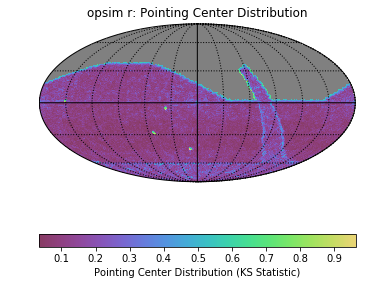

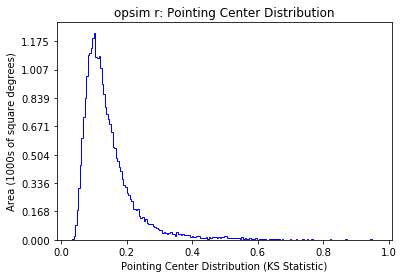

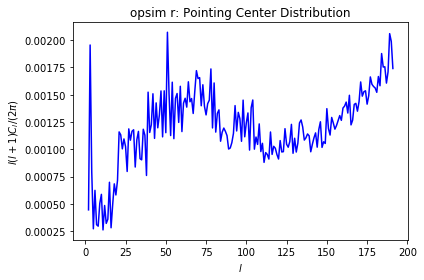

In [7]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
mbg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir)
mbg.runAll()
mbg.plotAll(closefigs=False)
conn.close()

I think I understand what's going on here:

* The DD fields are not dithered in the feature based scheduler, so those points should be very non-uniform.
* areas near the edge of the survey should be very non-uniform
* preferentally avoiding the galactic plane makes the border stand out.

In [19]:
# OK, now let's look at minion
outDir='temp'
conn = db.OpsimDatabaseV3('minion_1016_sqlite.db')

In [31]:
bundleList = []
sql = 'filter="r"'
metric = AngleDist2PointingCenter(latCol='ditheredDec', lonCol='ditheredRA', degrees=False)
slicer = slicers.HealpixSlicer(nside=128, latCol='ditheredDec', lonCol='ditheredRA', latLonDeg=False)
dith_stack = stackers.DefaultDitherStacker(raCol='fieldRA', decCol='fieldDec', degrees=False, fieldIdCol='fieldID')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[dith_stack]))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database Summary with constraint filter="r" for columns ['fieldID', 'fieldDec', 'fieldRA', 'night']
Found 538713 visits
Running:  ['opsim_Pointing_Center_Distribution_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 233 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.150645  dipole: lon: -75.9541, lat: -13.3686, amp: 0.035248
Plotting complete.


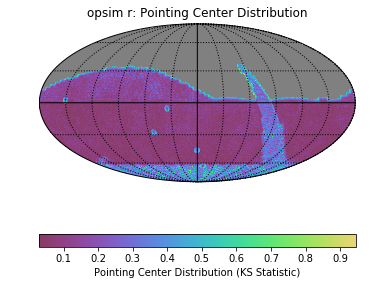

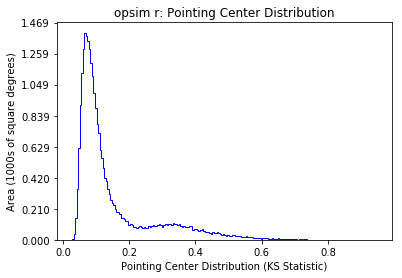

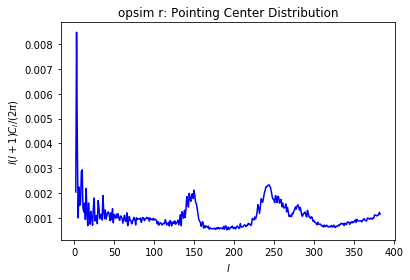

In [32]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
mbg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir)
mbg.runAll()
mbg.plotAll(closefigs=False)
conn.close()

Looking at minion

* Now the DD fields ARE dithered, so we get interesting donuts around them
* again, the borders of the survey are expected to be non-uniform
* Not sure why the SCP is non-uniform. Could be because it completes so early it doesn't go through as many of the dither steps as the rest of the survey
* slightly better median value than feature based scheduler (I think this is a known bug in feature based scheduler only rotating around one axis and will be fixed soon)